# Utilities

In [179]:
import os
import re
import typing

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

In [164]:
from sklearn.utils.fixes import _astype_copy_false
from sklearn.feature_extraction.text import _document_frequency
import scipy.sparse as sp
from sklearn.utils import _IS_32BIT
from sklearn.utils.validation import FLOAT_DTYPES
class MyTfidfTransformer(TfidfTransformer):
    """
    This class is identical to `sklearn.feature_extraction.text.TfidfTransformer`
    except this class uses the formula idf(t) = log(N / df(t)).

    More on `sklearn.feature_extraction.text.TfidfTransformer` at https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    """
    def fit(self, X, y=None):
        """Learn the idf vector (global term weights)
        using idf(t) = log(N / df(t)).

        Parameters
        ----------
        X : sparse matrix of shape n_samples, n_features)
            A matrix of term/token counts.

        y : None
            This parameter is not needed to compute tf-idf.

        Returns
        -------
        self : object
            Fitted transformer.
        """
        # large sparse data is not supported for 32bit platforms because
        # _document_frequency uses np.bincount which works on arrays of
        # dtype NPY_INTP which is int32 for 32bit platforms. See #20923
        X = self._validate_data(
            X, accept_sparse=("csr", "csc"), accept_large_sparse=not _IS_32BIT
        )
        if not sp.issparse(X):
            X = sp.csr_matrix(X)
        dtype = X.dtype if X.dtype in FLOAT_DTYPES else np.float64

        if self.use_idf:
            n_samples, n_features = X.shape
            df = _document_frequency(X)
            df = df.astype(dtype, **_astype_copy_false(df))

            # perform idf smoothing if required
            df += int(self.smooth_idf)
            n_samples += int(self.smooth_idf)

            # change idf formula
            idf = np.log(n_samples / df)
            self._idf_diag = sp.diags(
                idf,
                offsets=0,
                shape=(n_features, n_features),
                format="csr",
                dtype=dtype,
            )

        return self

In [ ]:
def violin_plot(dataset: list[np.ndarray], title: str, labels: list[str]) -> dict:
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_xticklabels([''] + labels)
    ax.grid()
    return ax.violinplot(dataset, showmeans=True)

In [183]:
colors = ('green', 'red', 'blue', 'orange', 'black', 'pink')

# Importing data

## Raw data

In [173]:
raw_lyrics_folder_path = 'Data_Final/data/song_lyrics'
genres = os.listdir(raw_lyrics_folder_path)
raw_song_count = []
for genre in genres:
    genre_folder_path = os.path.join(raw_lyrics_folder_path, genre)
    raw_song_count.append(len(os.listdir(genre_folder_path)))

[Text(0, 0, '1772'),
 Text(0, 0, '2261'),
 Text(0, 0, '1947'),
 Text(0, 0, '1624'),
 Text(0, 0, '1577'),
 Text(0, 0, '1605')]

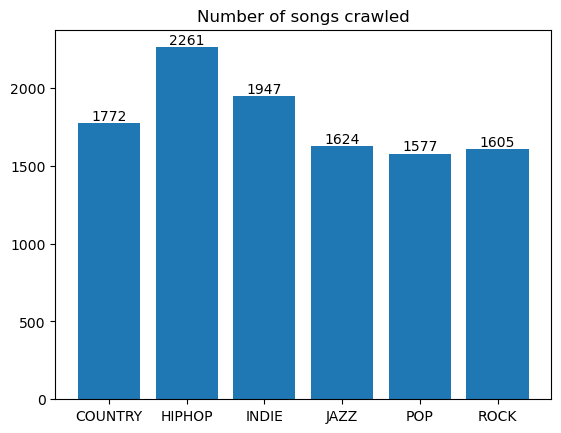

In [175]:
raw_data_fig, raw_data_ax = plt.subplots()
raw_data_ax.set_title("Number of songs crawled")
raw_data_ax.bar_label(raw_data_ax.bar(genres, raw_song_count), labels=raw_song_count)

## Cleaned data

The cleaned dataset contains data of 1500 songs for each genre.

In [ ]:
data = pd.read_csv('Data_Final/data/DS_data_final(2).csv')
data

In [ ]:
genres = [data['category'][0]]
first_song_indices = [0]
for i in range(1, len(data)):
    category = data['category'][i]
    if category != data['category'][i - 1]:
        genres.append(category)
        first_song_indices.append(i)

genres, first_song_indices

# Exploring the structure of song lyrics

Since song lyrics are often metrical rather than prose, it is worth examining the structure of song lyrics.

`word_frequency` is a matrix storing the frequency of every word in every song in our dataset. Each row corresponds to a song and each column corresponds to a word.

Each word is defined as a sequence of word characters surrounded by non-word characters (per Unicode's definition). All words are converted to lowercase before counting takes place. This means that the sentence "I'm counting words." is considered to have 4 words: "i", "m", "counting", and "words".

In [119]:
word_frequency_vectorizer = CountVectorizer(token_pattern=r"(?u)\b\w+\b")
word_frequency = word_frequency_vectorizer.fit_transform(data['song lyric'])

word_frequency

<9000x36388 sparse matrix of type '<class 'numpy.int64'>'
	with 1027762 stored elements in Compressed Sparse Row format>


## Word count

This section compares the word count of songs across genres. In each violin plot, the horizontal lines mark the minimum, mean, and maximum values.

In [100]:
song_word_count = word_frequency.sum(axis=1).getA1()

C:\Users\hxvie\AppData\Local\Temp\ipykernel_17480\243162542.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)


{'bodies': [<matplotlib.collections.PolyCollection at 0x16ec4f87880>,
 'cmeans': <matplotlib.collections.LineCollection at 0x16ec4f6aa90>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x16ec4f9f7f0>,
 'cmins': <matplotlib.collections.LineCollection at 0x16ec4f9fca0>,
 'cbars': <matplotlib.collections.LineCollection at 0x16ec528f190>}

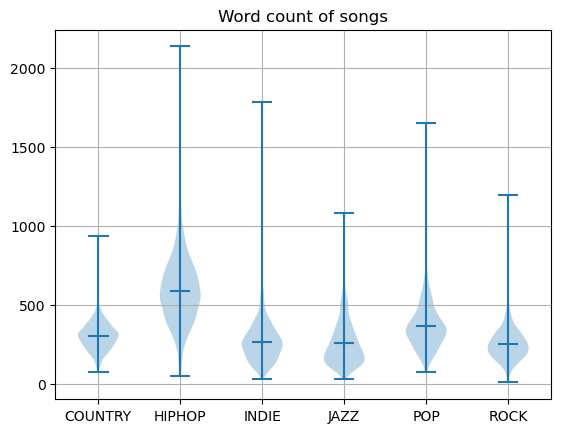

In [101]:
song_word_count_by_genre = np.split(song_word_count, first_song_indices[1:])
violin_plot(song_word_count_by_genre, "Word count of songs", genres)

## Vocabulary size

This section analyzes the number of unique words in each song and visualizes the distribution of this measure for each genre.

In [102]:
song_vocabulary_size = np.count_nonzero(word_frequency.toarray(), axis=1)

C:\Users\hxvie\AppData\Local\Temp\ipykernel_17480\243162542.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)


{'bodies': [<matplotlib.collections.PolyCollection at 0x16ec4f35e20>,
 'cmeans': <matplotlib.collections.LineCollection at 0x16ec4f35d30>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x16ec4f4ed90>,
 'cmins': <matplotlib.collections.LineCollection at 0x16ec4f43280>,
 'cbars': <matplotlib.collections.LineCollection at 0x16ec4f43730>}

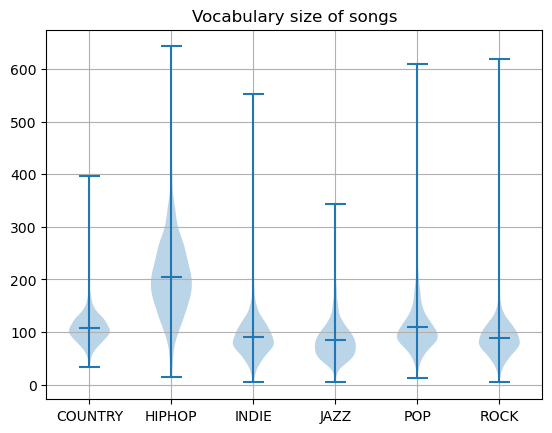

In [103]:
song_vocabulary_size_by_genre = np.split(song_vocabulary_size, first_song_indices[1:])
violin_plot(song_vocabulary_size_by_genre, "Vocabulary size of songs", genres)

## Average word frequency

Here we calculate the average word frequency (word count divided by vocabulary size) of each song. Higher numbers mean words tend to be repeated more frequently.

In [104]:
song_average_word_frequency = song_word_count / song_vocabulary_size

C:\Users\hxvie\AppData\Local\Temp\ipykernel_17480\243162542.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)


{'bodies': [<matplotlib.collections.PolyCollection at 0x16ec51ea610>,
 'cmeans': <matplotlib.collections.LineCollection at 0x16ec51c0d90>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x16ec50c7580>,
 'cmins': <matplotlib.collections.LineCollection at 0x16ec50c7a30>,
 'cbars': <matplotlib.collections.LineCollection at 0x16ec50c7ee0>}

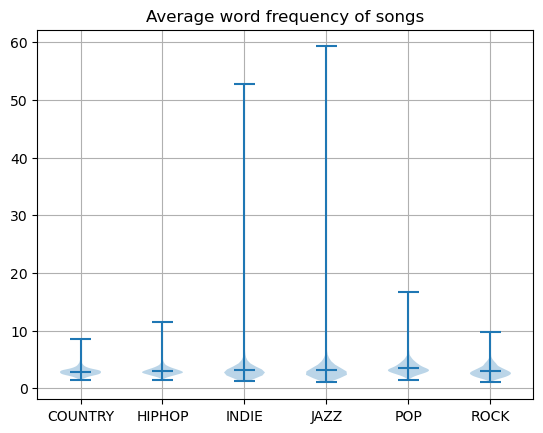

In [105]:
song_average_word_frequency_by_genre = np.split(song_average_word_frequency, first_song_indices[1:])
violin_plot(song_average_word_frequency_by_genre, "Average word frequency of songs", genres)

## Line count

In [106]:
song_line_count = np.zeros(len(data), dtype=np.int64)
for i in range(len(data)):
    lyrics = data['song lyric'][i]
    if lyrics != '':
        song_line_count[i] = lyrics.count('\n') + 1

C:\Users\hxvie\AppData\Local\Temp\ipykernel_17480\243162542.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)


{'bodies': [<matplotlib.collections.PolyCollection at 0x16ec4edad90>,
 'cmeans': <matplotlib.collections.LineCollection at 0x16ec4edaca0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x16ec4ea4d00>,
 'cmins': <matplotlib.collections.LineCollection at 0x16ec4eb81f0>,
 'cbars': <matplotlib.collections.LineCollection at 0x16ec4eb86a0>}

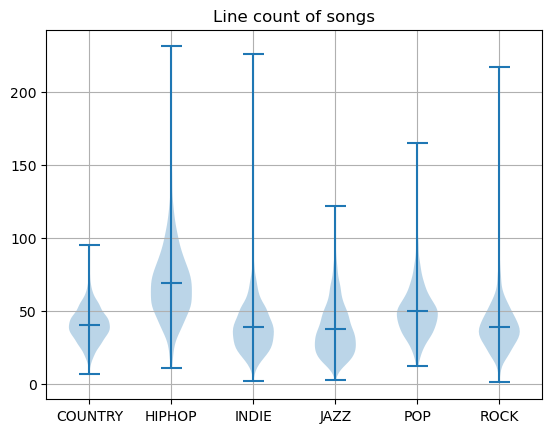

In [107]:
song_line_count_by_genre = np.split(song_line_count, first_song_indices[1:])
violin_plot(song_line_count_by_genre, "Line count of songs", genres)

## Average number of words per line

In [108]:
song_average_words_per_line = song_word_count / song_line_count

C:\Users\hxvie\AppData\Local\Temp\ipykernel_17480\243162542.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)


{'bodies': [<matplotlib.collections.PolyCollection at 0x16ec417a8e0>,
 'cmeans': <matplotlib.collections.LineCollection at 0x16ec4175d60>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x16ec418a850>,
 'cmins': <matplotlib.collections.LineCollection at 0x16ec418ad00>,
 'cbars': <matplotlib.collections.LineCollection at 0x16ec419a1f0>}

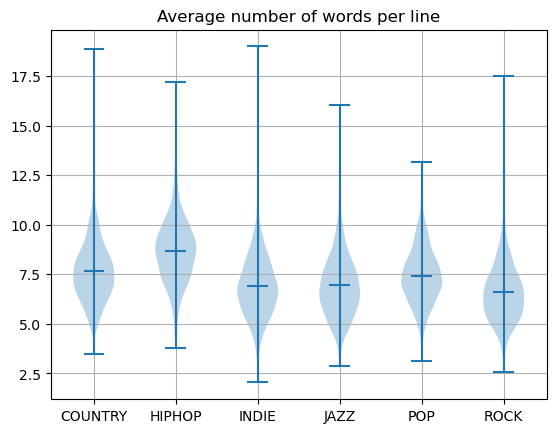

In [109]:
song_average_words_per_line_by_genre = np.split(song_average_words_per_line, first_song_indices[1:])
violin_plot(song_average_words_per_line_by_genre, "Average number of words per line", genres)

## Relationships among these measures

In [110]:
data['word count'] = song_word_count
data['vocabulary size'] = song_vocabulary_size
data['line count'] = song_line_count

<AxesSubplot:>

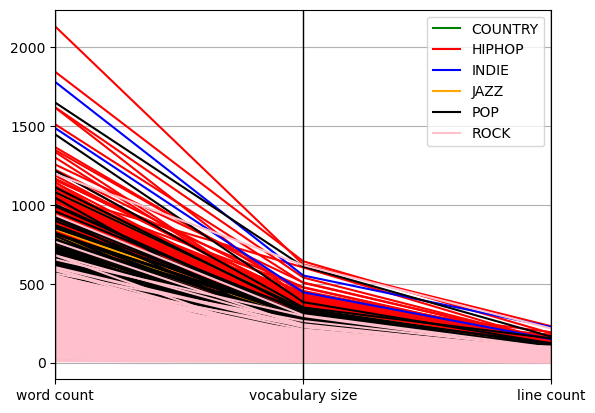

In [184]:
pd.plotting.parallel_coordinates(frame=data,
                                 class_column='category',
                                 cols=['word count', 'vocabulary size', 'line count'],
                                 color=colors)

# Exploring the meaning of song lyrics

In [122]:
vocabulary = word_frequency_vectorizer.get_feature_names_out()

## Top 10 most frequent words

The top 10 most frequent words are probably going to be the same for all genres - they're all going to be grammatical words that don't carry much meaning - but it's still worth taking a look at them.

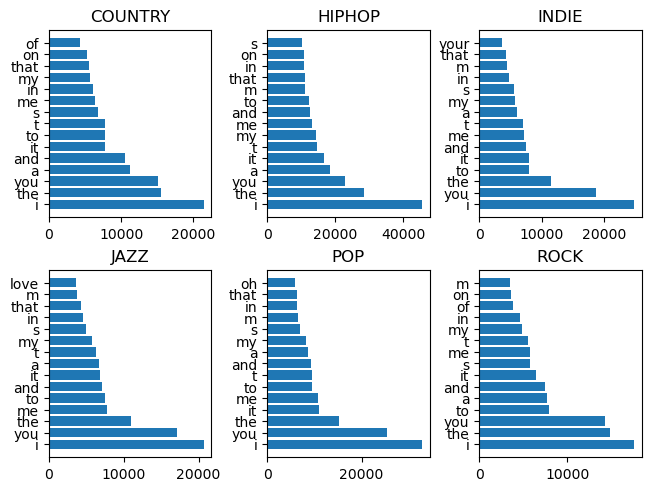

In [162]:
frequent_words_fig, frequent_words_axs = plt.subplots(2, 3, constrained_layout=True)
for i in range(len(genres)):
    if i < len(genres) - 1:
        this_genre_word_frequency = word_frequency[first_song_indices[i]:first_song_indices[i+1]]
    else:
        this_genre_word_frequency = word_frequency[first_song_indices[i]:]
    this_genre_word_frequency = this_genre_word_frequency.sum(axis=0).getA1()
    indices = np.argsort(- this_genre_word_frequency)[:15]
    words = vocabulary[indices]
    frequencies = this_genre_word_frequency[indices]
    axes = frequent_words_axs[divmod(i, 3)]
    axes.set_title(genres[i])
    axes.barh(words, frequencies)

## Top 10 words with highest average tf-idf

This part computes the tf-idf of each word in each song in our dataset and finds the top words with the highest average tf-idf for each genre. These words for each genre can be interpreted as the most important on average to the meaning of songs of the genre.

We're going to use the class `MytfidfTransformer` which redefines `sklearn.feature_extraction.text.TfidfTransformer` to use a different definition of idf: $idf(t) = {\log \frac{N}{df(t)}}$. This increases the effect of ignoring words that occur in all or almost all songs.

In [165]:
tfidf = MyTfidfTransformer(smooth_idf=False, sublinear_tf=True).fit(word_frequency).transform(word_frequency)

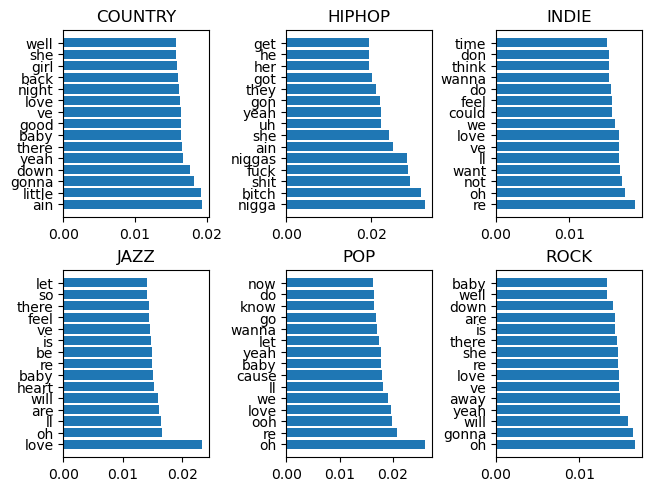

In [166]:
important_words_fig, important_words_axs = plt.subplots(2, 3, constrained_layout=True)
for i in range(len(genres)):
    if i < len(genres) - 1:
        this_genre_tfidf = tfidf[first_song_indices[i]:first_song_indices[i+1]]
    else:
        this_genre_tfidf = tfidf[first_song_indices[i]:]
    this_genre_tfidf = this_genre_tfidf.mean(axis=0).getA1()
    indices = np.argsort(- this_genre_tfidf)[:15]
    words = vocabulary[indices]
    frequencies = this_genre_tfidf[indices]
    axes = important_words_axs[divmod(i, 3)]
    axes.set_title(genres[i])
    axes.barh(words, frequencies)

## tf-idf matrix principal component analysis

In [191]:
tfidf_pca = TruncatedSVD().fit_transform(tfidf)
tfidf_pca_min_comp1, tfidf_pca_min_comp2 = tfidf_pca.min(axis=0)
tfidf_pca_max_comp1, tfidf_max_comp2 = tfidf_pca.max(axis=0)

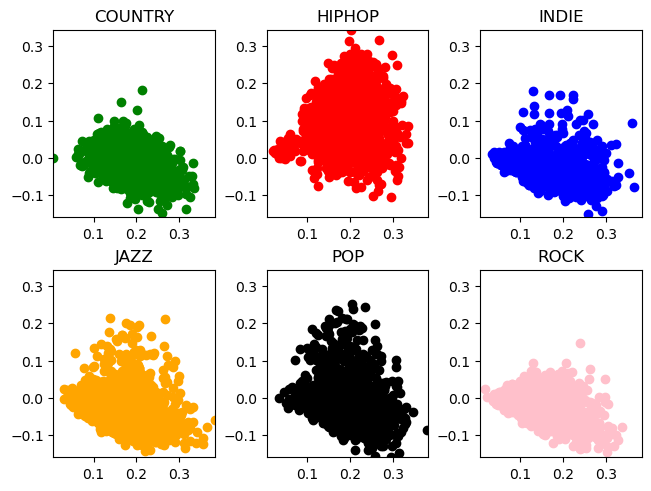

In [192]:
tfidf_pca_fig, tfidf_pca_axs = plt.subplots(2, 3, constrained_layout=True)
for i in range(len(genres)):
    if i < len(genres) - 1:
        this_genre_tfidf_pca = tfidf_pca[first_song_indices[i]:first_song_indices[i+1]]
    else:
        this_genre_tfidf_pca = tfidf_pca[first_song_indices[i]:]
    axes = tfidf_pca_axs[divmod(i, 3)]
    axes.set_title(genres[i])
    axes.set_xlim(tfidf_pca_min_comp1, tfidf_pca_max_comp1)
    axes.set_ylim(tfidf_pca_min_comp2, tfidf_max_comp2)
    axes.scatter(this_genre_tfidf_pca[:, 0], this_genre_tfidf_pca[:, 1], color=colors[i])